In [1]:
suppressMessages(library(magrittr)) 
suppressMessages(library(genefilter))
suppressMessages(library(DESeq2))
suppressMessages(library(readr))
suppressMessages(library(data.table))
suppressMessages(library(matrixStats))
suppressMessages(library(pheatmap))
suppressMessages(library(gplots))
suppressMessages(library(matrixStats))
suppressMessages(library(ggvenn))
suppressMessages(library(edgeR))
suppressMessages(library(pROC))
suppressMessages(library(ggpubr))
suppressMessages(library(eulerr))
suppressMessages(library(stringr))
suppressMessages(library(qualpalr))
suppressMessages(library(stats))
suppressMessages(library(tidyr))
suppressMessages(library(pROC))
suppressMessages(library(binom))
options(stringsAsFactors = FALSE)
set.seed(42)
gene.list = read.delim("../Files_For_Manuscript/gencode.biotype.name.key.tsv")


Warning message:
“package ‘genefilter’ was built under R version 4.2.2”
Warning message:
“package ‘DESeq2’ was built under R version 4.2.2”
Warning message:
“package ‘S4Vectors’ was built under R version 4.2.1”
Warning message:
“package ‘BiocGenerics’ was built under R version 4.2.1”
Warning message:
“package ‘IRanges’ was built under R version 4.2.1”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.2.2”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.2.3”
Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.2.2”
Warning message:
“package ‘MatrixGenerics’ was built under R version 4.2.1”
Warning message:
“package ‘Biobase’ was built under R version 4.2.1”
Warning message:
“package ‘edgeR’ was built under R version 4.2.3”
Warning message:
“package ‘limma’ was built under R version 4.2.3”
Warning message:
“package ‘ggpubr’ was built under R version 4.2.2”


# Create the Metadata for this 

In [2]:
# Read in cfRNA files
metadata_train = read.delim("../Files_For_Manuscript/metadata.train.tsv")
metadata_test = read.delim("../Files_For_Manuscript/metadata.test.tsv")
metadata_val = read.delim("../Files_For_Manuscript/metadata.val.tsv")
cto_discovery =read.delim("../Files_For_Manuscript/discovery_cell_types.tsv")
# Read in whole blood files
cto_wb =  read.delim("../Files_For_Manuscript/cto_wb.txt")
meta_wb =read.delim("../Files_For_Manuscript/wb_metadata.txt")

# Assign label for wbRNA samples
meta = meta_wb %>% select(sample_id, site, cohort, hiv, tb) %>% tibble::add_column("Biofluid"="WBRNA")

metadata_discovery = rbind(metadata_train, metadata_test, metadata_val)

# Select only valid columns
cto_discovery <- cto_discovery %>% 
   filter(sample_id %in% metadata_discovery$sample_id)

# Select only valid columns
meta = meta %>% 
   filter(sample_id %in% cto_wb$sample_id)
nrow(cto_discovery)
nrow(meta)

# Combine metadata for plasma samples and wbRNA samples
combined_metadata = metadata_discovery %>% select(sample_id, site, cohort, hiv, tb) %>% 
tibble::add_column("Biofluid"="plasma") %>% 
rbind(. , meta)


[1] 251

[1] 60

In [3]:
# Combine the cell type dataframes from Whole blood and cfRNA
decon = rbind(cto_discovery, cto_wb)
# Melt the dataframe, reassign column names for legibility and merge with metadata
decon_melt = unique(melt(decon, id.vars="sample_id") %>% rename(celltype = variable, fraction = value)  %>%
    merge(. , combined_metadata, by.x="sample_id", by.y="sample_id"))


Warning message in melt(decon, id.vars = "sample_id"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(decon). In the next version, this warning will become an error.”


In [4]:
# Calculate the average fraction across cell types
results <- decon_melt
sum <- results %>% group_by(celltype) %>% summarize(mean=mean(fraction))
sum <- sum[order(sum$mean,decreasing=TRUE),]

genes = sum$celltype

num_cells = length(genes)
pal = sample(rev(qualpal(num_cells, colorspace=list(h=c(0,360), s=c(0.3,1), l=c(0.2,0.8)))$hex))
pal = c('#1362AB','#740C33','#2C8DAF','#FB927F','#5CFBF4','#0234C1','#86C35E','#B414A8','#F191B8','#949D0A','#700862','#F5DB9E','#209510','#DBB008','#5C6BFA','#B27DF2','#D6F306','#5EFE36','#A9DAC9','#B2040D','#203760','#4D5D0D','#4A1E80','#F63DFA','#F8169B','#175738','#0C8559','#A1506B','#861FF1','#2BBBB3','#5E210C','#36B976','#CAA376','#D75E16','#73480D','#39F9AD','#85D2F8','#65A2FC','#FC092B','#94A514','#AEBBE6')

colors = pal
labels = genes

val_vector = colors
names(val_vector) = labels

In [5]:
solid_labels = c('Fibroblast mesenchymal stem cell',
                'Endothelial.cell',
    'Respiratory.ciliated.cell',
                 'Ionocyte.luminal.epithelial.cell.of.mammary.gland','Kidney.epithelial.cell',
                 'Cell.of.skeletal.muscle','Intestinal.tuft.cell',
    'Intestinal.enterocyte',
                 'Prostate.epithelia',
    'Salivary.bronchial.secretory.cell',
    'Intestinal.secretory.cell',
                 'Secretory.cell','Respiratory.secretory.cell','Basal.prostate.cell','Basal.cell',
                 'Salivary.gland.cell','Pancreatic.Stellate.cell','Type.II.Pneumocyte',
                 'Intrahepatic.cholangiocyte','Gland.cell','Mesothelial cell',
    'Schwann.cell',
                 'Pancreatic.alpha.beta.cell','Tendon cell',
    'Pericyte.cell')
solid_colors = colors[1:25]

val_vector_solid = solid_colors

names(val_vector_solid) = solid_labels

val_vector_solid = val_vector_solid[order(match(names(val_vector_solid),genes))]

In [6]:
newtot =results  %>% filter(celltype !="Platelet") %>% group_by(sample_id) %>% summarise(newtot = sum(fraction))
newresults = results %>% filter(celltype != "Platelet")
newresults = merge(newtot, newresults, by="sample_id")
newresults$newfraction = (newresults$fraction)*(1/newresults$newtot)
newresults$cohort[grepl("WBRNA", newresults$sample_id)]="WBRNA"
res_melt_solid = newresults[which(newresults$celltype %in% names(val_vector_solid)),]


`summarise()` has grouped output by 'sample_id'. You can override using the `.groups` argument.
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


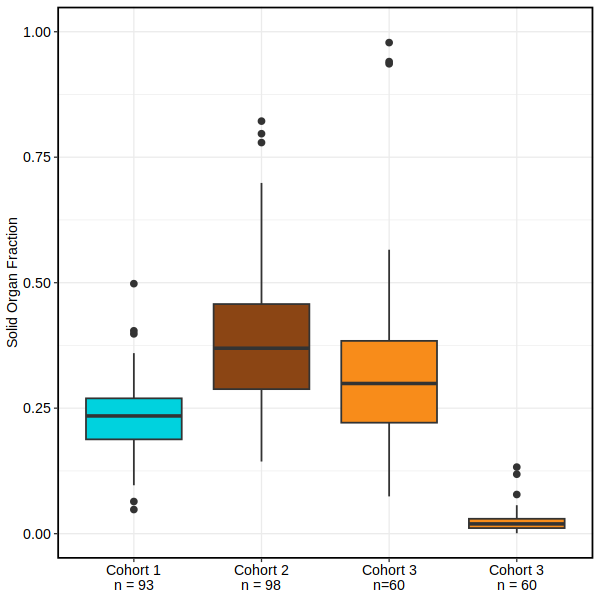

In [7]:
options(repr.plot.height=5, repr.plot.width=5)
my_comparisons <- list( c("END TB", "WBRNA"), c("R2D2", "WBRNA"), c("TB2", "WBRNA") )

p = res_melt_solid %>% 
    mutate(celltype = factor(celltype,levels=genes)) %>% group_by(sample_id, cohort) %>% summarise(val=sum(newfraction)) %>%
    ggplot(aes(x=cohort,y=val, fill=cohort)) + geom_boxplot() + theme_bw(base_size=8) + 
scale_x_discrete(labels=c("Cohort 1\nn = 93", "Cohort 2\nn = 98","Cohort 3\nn=60", "Cohort 3\nn = 60")) + 
theme(axis.title.x=element_blank(),
      axis.text.x=element_text(color="black", angle=0, size=8.5),
     axis.text.y=element_text(color="black", size=8.5),
     axis.title.y=element_text(color="black", size=8.5),
     legend.position="none", panel.border = element_rect(size = 1, color ="black")) + 
ylab("Solid Organ Fraction") +ylim(0,1) +
scale_fill_manual(values=c("#00D2DE", "#8B4514", "#F88C1A", "#F88C1A"))


p 
ggsave("../Figure_Output/Figure_3/Figure_3C.pdf", plot = p, width = 2.85, height = 2, device = "pdf")

ggsave("../Figure_Output/Figure_3/Figure_3C.png", plot = p, width = 2.85, height = 2)


In [8]:
## Calculate the padj significance for each comparison ##
# Set comparisons
comparisons <- list(
  c("GHL", "WBRNA"), 
  c("R2D2", "WBRNA"), 
  c("TBSQUARE", "WBRNA")
)

# Initialize empty vector for p-values
p_values <- numeric(length(comparisons))

# Temp dataframe
df_stat = res_melt_solid %>% 
mutate(celltype = factor(celltype,levels=genes)) %>% 
group_by(sample_id, cohort) %>% summarise(val=sum(newfraction))
# Loop through each comparison and perform Wilcoxon test
for (i in seq_along(comparisons)) {
  group1 <- comparisons[[i]][1]
  group2 <- comparisons[[i]][2]

  data_group1 <- filter(df_stat, cohort == group1)$val
  data_group2 <- filter(df_stat, cohort == group2)$val

  test_result <- wilcox.test(data_group1, data_group2)
  p_values[i] <- test_result$p.value
}

# Adjust the p-values using Benjamini-Hochberg method
adjusted_p_values <- p.adjust(p_values, method = "BH")

print("padj values for solid organ comparisons")
print(paste0("Cohort 1 <-> wbRNA: ", adjusted_p_values[1]))
print(paste0("Cohort 2 <-> wbRNA: ", adjusted_p_values[2]))
print(paste0("Cohort 3 <-> wbRNA: ", adjusted_p_values[3]))

`summarise()` has grouped output by 'sample_id'. You can override using the `.groups` argument.


[1] "padj values for solid organ comparisons"
[1] "Cohort 1 <-> wbRNA: 6.5691628804906e-25"
[1] "Cohort 2 <-> wbRNA: 1.86163393818428e-25"
[1] "Cohort 3 <-> wbRNA: 4.56784091382928e-21"


## FIG 4D

## DESEQ for cfRNA

In [9]:
#Set Seed 
set.seed(87)

# Read in  Counts
counts_train = read.delim("../Files_For_Manuscript/counts.train.tsv") %>%t()
counts_test = read.delim("../Files_For_Manuscript/counts.test.tsv") %>%t()
counts_val = read.delim("../Files_For_Manuscript/counts.val.tsv") %>%t()
# Cobine Counts
counts_all = rbind(counts_train, counts_test, counts_val) %>% t()

# Read in Metadata
metadata_train = read.delim("../Files_For_Manuscript/metadata.train.tsv")
metadata_test = read.delim("../Files_For_Manuscript/metadata.test.tsv")
metadata_val = read.delim("../Files_For_Manuscript/metadata.val.tsv")
# Combine Metadata
metadata_all = rbind(metadata_train, metadata_test, metadata_val)

In [10]:
## Prepare data for Deseq2
meta_col = metadata_all
disc_cts = counts_all
meta_col = meta_col %>% select("sample_id", "tb")
rownames(meta_col) = meta_col$sample_id  

all(colnames(disc_cts) == rownames(meta_col))       


## run Deseq2 & extract results
dds <- DESeqDataSetFromMatrix(countData = disc_cts,
                             colData = meta_col,
                             design = ~ tb)
dds <- DESeq(dds)
res <- results(dds)

## Extract results
res_df_cf = results(dds,alpha=0.05,contrast = c("tb","positive", "negative")) %>% data.frame()
res_df_cf$gene_num = rownames(res_df_cf)
sigs_cf = res_df_cf %>% filter(padj<0.05)



[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 357 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



## DESEQ Whole Blood

In [11]:
## Prepare data for Deseq2
## Filter out blacklist genes
## This same step was done to cfRNA samples pre-processing
blacklist = read.delim("../Files_For_Manuscript/genes_to_exlude.tsv",header=F)
counts_wb = read.delim("../Files_For_Manuscript/count_matrix_wbrna.txt")
row.names(counts_wb) = counts_wb$geneID
counts_wb = counts_wb %>% select(-geneID)
# Remove blacklist genes
counts_wb = counts_wb[!(gsub("\\..*","",rownames(counts_wb)) %in% blacklist$V2),]
meta_wb = read.delim("../Files_For_Manuscript/wb_metadata.txt")

meta_col = meta_wb

disc_cts = counts_wb

meta_col = meta_col %>% select("sample_id", "tb")        
rownames(meta_col) = meta_col$sample_id 

disc_cts<- disc_cts[, match(rownames(meta_col), colnames(disc_cts))]

all(colnames(disc_cts) == rownames(meta_col))   


## run Deseq2 & extract results
dds <- DESeqDataSetFromMatrix(countData = disc_cts,
                             colData = meta_col,
                             design = ~ tb)
dds <- DESeq(dds)
res <- results(dds)

## Extract results
res_df = results(dds,alpha=0.05,contrast = c("tb","Positive", "Negative")) %>% data.frame()
res_df$gene_num = rownames(res_df)
sigs_wb = res_df %>% filter(padj<0.05)


[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 27869 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [12]:
# Total number of significant plasma genes
sig_genes_plasma = sigs_cf %>% row.names()
# Total number of significant whole blood RNA genes
sig_genes_wb = sigs_wb %>% row.names() 
# Number that intersect
intersect(sig_genes_plasma,sig_genes_wb) %>% length()
u_pl = length(sig_genes_plasma)
u_wb = length(sig_genes_wb)
int =  intersect(sig_genes_plasma,sig_genes_wb) %>% length()

[1] 517

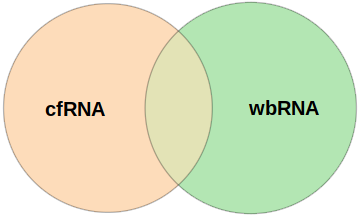

In [13]:
options(repr.plot.height=1.8, repr.plot.width=3)

VennDiag = euler(c("cfRNA"=u_pl, "wbRNA"=u_wb, "cfRNA&wbRNA"=int))
p = plot(VennDiag, counts=TRUE, fill=c("#F88C1A", "#00AC00"), alpha=0.3)
p
ggsave("../Figure_Output/Figure_3/Figure_3D.pdf", plot = p, width = 7.2, height = 12, device = "pdf")

ggsave("../Figure_Output/Figure_3/Figure_3D.png", plot = p, width = 7.2, height = 12)


---
## FIG 3E

In [14]:
# Read and Wrangle Data #

# Read in Counts
counts_train = read.delim("../Files_For_Manuscript/counts.train.tsv")
counts_test = read.delim("../Files_For_Manuscript/counts.test.tsv")
counts_val = read.delim("../Files_For_Manuscript/counts.val.tsv")

# Read in Metadata
metadata_train = read.delim("../Files_For_Manuscript/metadata.train.tsv")
metadata_test = read.delim("../Files_For_Manuscript/metadata.test.tsv")
metadata_val = read.delim("../Files_For_Manuscript/metadata.val.tsv")

counts_train_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_train)) %>% data.frame() 
counts_test_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_test)) %>% data.frame() 
counts_val_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_val)) %>% data.frame() 

#train data
norm_plot_dat_train = counts_train_norm %>% #t() %>%
    as.data.frame() %>% 
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_train = merge(norm_plot_dat_train, metadata_train, by.x = "sample_id")

#test data
norm_plot_dat_test = counts_test_norm %>% #t() %>%
    as.data.frame() %>% 
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_test = merge(norm_plot_dat_test, metadata_test, by.x = "sample_id")

#Validation data
norm_plot_dat_val = counts_val_norm %>%# t() %>%
    as.data.frame() %>% 
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_val = merge(norm_plot_dat_val, metadata_val, by.x = "sample_id")

# Combine all samples
norm_plot_dat_all = rbind(norm_plot_dat_train, norm_plot_dat_test, norm_plot_dat_val)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "GBP5 ROC-AUC: 0.879"
[1] "GBP5 ROC-AUC 95% CI: [0.836--0.922]"
[1] "GBP5 Sensitivity:  0.831 95% CI: [ 0.761 , 0.884 ]"
[1] "GBP5 Specificity:  0.826 95% CI: [ 0.744 , 0.885 ]"


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


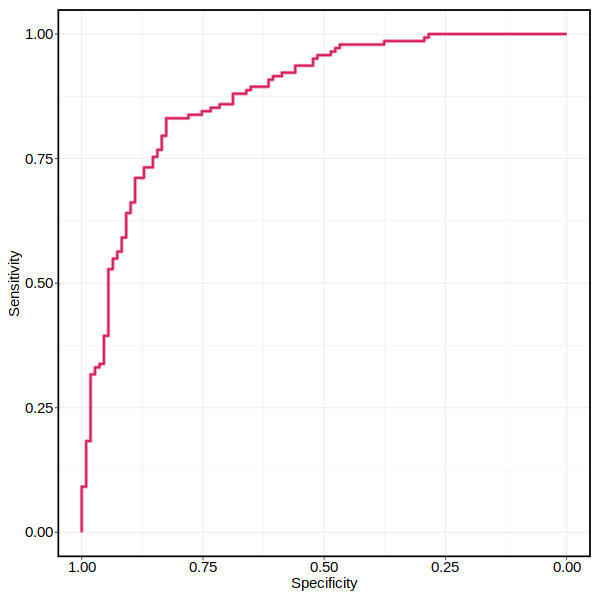

In [15]:
options(repr.plot.height=5, repr.plot.width=5)

# Temporary dataframe for all points
df <- norm_plot_dat_all

# Make tb binary factor
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)

# Use GBP5 counts for ROC analysis
gbp5_counts <- df$ENSG00000154451.14

# Compute ROC-AUC
roc_train <- roc(df$tb, gbp5_counts)
auc_train = auc(roc_train)

# Calculate Youden index and find the best threshold
coords_df <- data.frame(coords(roc_train, "all"))
coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1
optimal <- coords_df[which.max(coords_df$youden),]

# Print ROC and 95% CI
roc_train_ci = ci.auc(roc_train)
print(paste0("GBP5 ROC-AUC: ", round(auc_train, 3)))
print(paste0("GBP5 ROC-AUC 95% CI: [", round(roc_train_ci[1], 3), "--", round(roc_train_ci[3], 3), "]"))

# Assign labels using optimal threshold
df$predicted <- ifelse(gbp5_counts > optimal$threshold, 1, 0)

# Create a confusion matrix
conf_matrix <- table(df$tb, df$predicted)

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

# Calculate 95% Confidence Intervals for Sensitivity and Specificity
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")

# Print Sensitivity, Specificity and their CIs
print(paste("GBP5 Sensitivity: ", round(sensitivity, 3), 
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))
print(paste("GBP5 Specificity: ", round(specificity, 3), 
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

# Plotting the ROC curve
p <- ggroc(list("Train" = roc_train), aes = c("color"))  +
    theme_bw(base_size = 6) + guides(color = "none", linetype = "none") +
    geom_line(size = 1, alpha = 0.5) + scale_color_manual(values = c("#D71B5A")) +
    xlab("Specificity") + ylab("Sensitivity") +
    theme(axis.text = element_text(size = 9, color = "black"), 
          axis.title = element_text(size = 9, color = "black"),
          panel.border = element_rect(size = 1, color ="black"),
          plot.margin = margin(5.5, 5.5, 5.5, 5.5, "points"))

# Display the plot
print(p)

# Save the plot
ggsave("../Figure_Output/Figure_3/Figure_3E.pdf", plot = p, width = 2, height = 2, device = "pdf")
ggsave("../Figure_Output/Figure_3/Figure_3E.png", plot = p, width = 2, height = 3.5, dpi = 300)
